In [3]:
# Download the FER-2013 dataset from kaggle
# !pip install kaggle
!kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Extract the zip in a dataset folder
!unzip -q utkface-new.zip -d assets/dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense, 
    GlobalAveragePooling2D, 
    Dropout, 
    Conv2D, 
    Flatten, 
    MaxPooling2D, 
    Input, 
    BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [4]:
BASE_DIR = 'assets/dataset/UTKFace'

In [5]:
image_paths, age_labels, gender_labels = [], [], []
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})
gender_dict = {0: 'Male', 1: 'Female'}

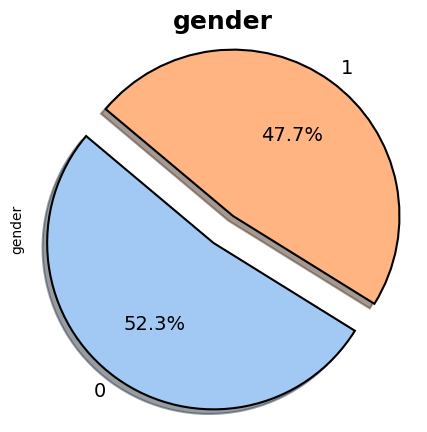

In [11]:
def plot_data(name, data):
    plt.figure(figsize=(5, 5))
    palette_color = sns.color_palette('pastel')
    explode = [0.1 for _ in range(data.nunique())]

    target_counts = df.groupby(name)[name].count()

    target_counts.plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5} 
    )

    plt.title(name, fontsize=18, weight='bold')
    plt.axis('equal')
    plt.show()


plot_data('gender', df['gender'])

C:\Users\froms\AppData\Local\Temp\ipykernel_27044\1462740167.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age']);


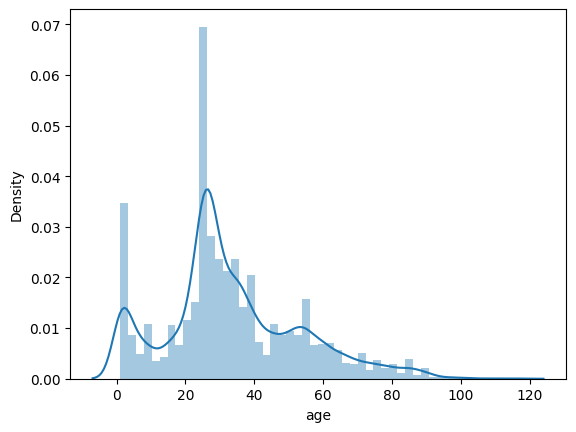

In [12]:
sns.distplot(df['age']);

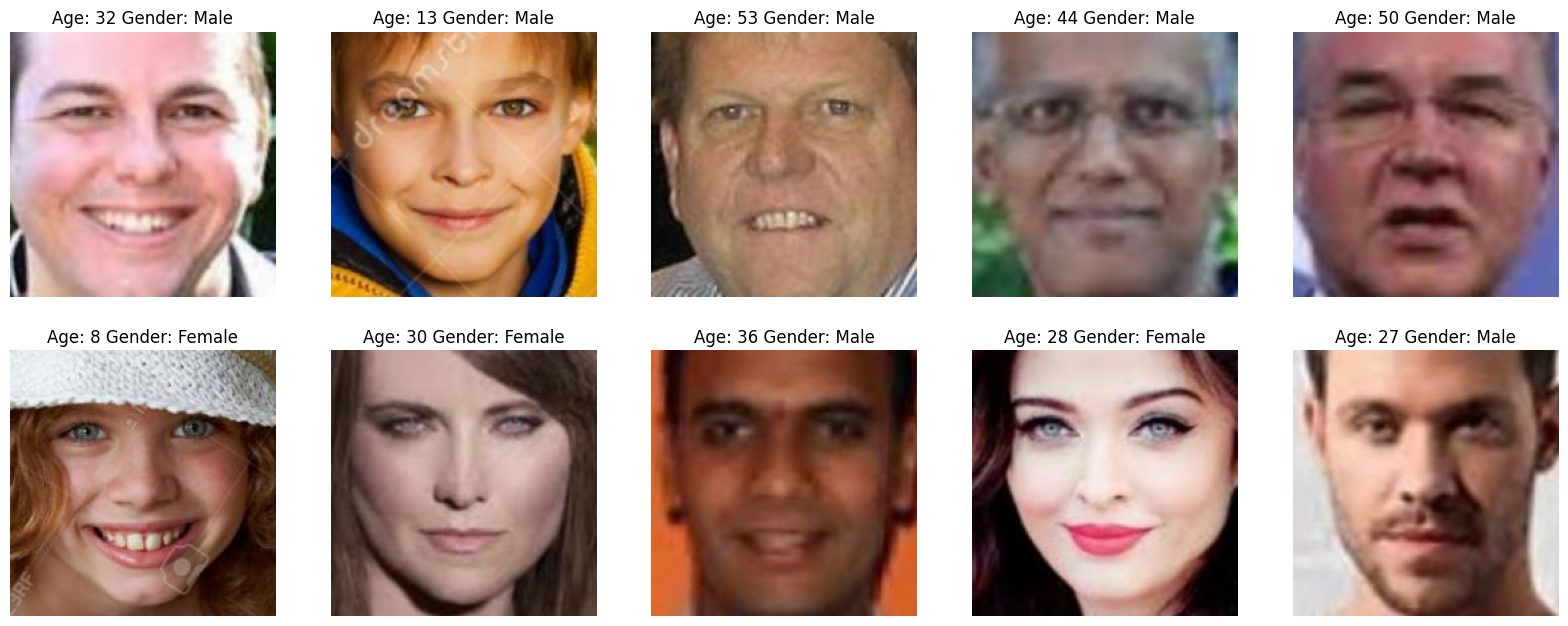

In [4]:
plt.figure(figsize=(20, 20))
files = df.sample(10)

for index, (file, age, gender) in enumerate(files[['image', 'age', 'gender']].values):
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [6]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='rgb')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
    features = np.array(features) / 255.0
    return features

X = extract_features(df['image'])
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

  0%|          | 0/23708 [00:00<?, ?it/s]

# `ResNet50`

In [ ]:
base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

gender_output = Dense(1, activation='sigmoid', name='gender_out')(x)
age_output = Dense(1, activation='linear', name='age_out')(x)

model = Model(inputs=base_model.input, outputs=[gender_output, age_output])

model.compile(
    loss=['binary_crossentropy', 'mae'], 
    optimizer='adam', 
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
    )

# `CNN`

In [ ]:
inputs = Input((128, 128, 3))

conv_1 = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv_1') (inputs)
batch_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal') (batch_1)
maxp_1 = MaxPooling2D() (conv_2)
dropout_1 = Dropout(0.25) (maxp_1)

flatten = Flatten() (dropout_1)

# fully connected layers
dense_1 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)
dense_2 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)

batch_2 = BatchNormalization() (dense_1)
batch_3 = BatchNormalization() (dense_2)

dropout_2 = Dropout(0.5) (batch_2)
dropout_3 = Dropout(0.5) (batch_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_2)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_3)


model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [ ]:
history = model.fit(
    X, [y_gender, y_age], 
    batch_size=32, epochs=30, 
    validation_split=0.2, 
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )

# evaluate

In [ ]:
# Save the model (choose one of the options)
model.save('models/custom_ResNet50.h5')  # HDF5 format
# or
model.save('models/custom_ResNet50.keras')  # SavedModel format

# Save the history
np.savez('custom_ResNet50_history.npz', **history.history)

In [2]:
# Load the model
model = tf.keras.models.load_model('models/custom_CNN/custom_CNN.keras')

c:\Users\froms\anaconda3\envs\si\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Gender: Male Predicted Age: 12


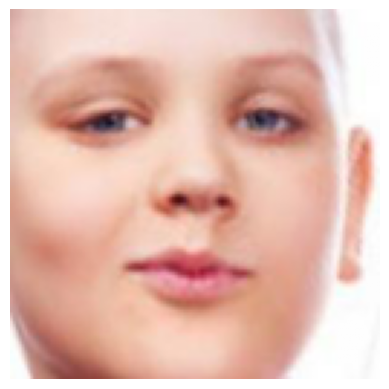

In [12]:
image_index = 58
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# preprocess the image
input_image = X[image_index].reshape(128, 128, 3)  # assuming the image is RGB
input_image = np.expand_dims(input_image, axis=0)  # add batch dimension

# predict from model
pred = model.predict(input_image)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3))